# Single Node Capacity Expansion Planning

## From electricity market modelling to capacity expansion planning

Review the problem formulation of the electricity market model. Below you can find an adapted version
where the capacity limits have been promoted to **decision variables** with corresponding terms
in the *objective function* and *new constraints for their expansion limits* (e.g. wind and solar potentials). This is known as **capacity expansion problem**.

$$
\begin{equation*}
    \min_{g,e,f,G,E,F} \quad \sum_{i,s,t} w_t o_{s} g_{i,s,t} + \sum_{i,s} c_sG_{i,s}  + c_{r,\text{dis/charge}}G_{i,r, \text{dis/charge}} +   c_{r}E_{i,r}  + c_\ell F_{\ell}
  \end{equation*}
$$
such that
$$
  \begin{align*}
    d_{i,t} &= \sum_s g_{i,s,t}  - \sum_\ell K_{i\ell} f_{\ell,t}   & \text{energy balance} \\
    0 &\leq g_{i,s,t} \leq \hat{g}_{i,s,t} G_{i,s} & \text{generator limits}\\
    0 & \leq g_{i,r,t,\text{dis/charge}} \leq G_{i,r,\text{dis/charge}}& \text{storage dis/charge limits} \\
    0 & \leq e_{i,r,t} \leq E_{r} & \text{storage energy limits} \\ 
    e_{i,r,t} &= \eta^0_{i,r,t} e_{i,r,t-1} + \eta^1_{r}g_{i,r,t,\text{charge}} -  \frac{1}{\eta^2_{r}} g_{i,r,t,\text{discharge}} & \text{storage consistency} \\
    -F_\ell &\leq f_{\ell,t} \leq F_\ell  & \text{line limits} \\
    0 &= \sum_\ell C_{\ell c} x_\ell f_{\ell,t} & \text{KVL} \\
        \underline{G}_{i,s} & \leq G_{i,s} \leq \overline{G}_{i,s} & \text{generator capacity expansion limits} \\
    \underline{G}_{i,r, \text{dis/charge}} & \leq G_{i,r, \text{dis/charge}} \leq \overline{G}_{i,r, \text{dis/charge}} & \text{storage power capacity expansion limits} \\
    \underline{E}_{i,r} & \leq E_{i,r} \leq \overline{E}_{i,r} & \text{storage energy expansion limits} \\
    \underline{F}_{\ell} & \leq F_{\ell} \leq \overline{F}_{\ell} & \text{line capacity expansion limits}
  \end{align*}
$$

**New decision variables for capacity expansion planning:**

- $G_{i,s}$ is the generator capacity at bus $i$, technology $s$,
- $F_{\ell}$ is the transmission capacity of line $\ell$,
- $G_{i,r,\text{dis-/charge}}$ denotes the charge and discharge capacities of storage unit $r$ at bus $i$,
- $E_{i,r}$ is the energy capacity of storage $r$ at bus $i$ and time step $t$.

**New parameters for capacity expansion planning:**

- $c_{\star}$ is the capital cost of technology $\star$ at bus $i$
- $w_t$ is the weighting of time step $t$ (e.g. number of hours it represents)
- $\underline{G}_\star, \underline{F}_\star, \underline{E}_\star$ are the minimum capacities per technology and location/connection.
- $\underline{G}_\star, \underline{F}_\star, \underline{E}_\star$ are the maximum capacities per technology and location.

:::{note}
For a full reference to the optimisation problem description, see https://pypsa.readthedocs.io/en/latest/optimal_power_flow.html
:::


First things first! We need a few packages for this tutorial:

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

import pypsa

plt.style.use("bmh")

## Prerequisites: handling technology data and costs

We maintain a database (https://github.com/PyPSA/technology-data) which collects assumptions and projections for energy system technologies (such as costs, efficiencies, lifetimes, etc.) for given years, which we can load into a `pandas.DataFrame`. This requires some pre-processing to load (e.g. converting units, setting defaults, re-arranging dimensions):

In [7]:
year = 2030
costs = pd.read_csv(f"../../data/costs/costs_{year}.csv", index_col=[0, 1])

In [8]:
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["CCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]
costs.at["CCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

Let's also write a small utility function that calculates the **annuity** to annualise investment costs. The formula is

$$
a(r, n) = \frac{r}{1-(1+r)^{-n}}
$$
where $r$ is the discount rate and $n$ is the lifetime.

In [9]:
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

In [10]:
annuity(0.07, 20)

0.09439292574325567

Based on this, we can calculate the short-term marginal generation costs (STMGC, €/MWh):

In [11]:
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

and the annualised investment costs (`capital_cost` in PyPSA terms, €/MW/a):

In [12]:
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)

In [13]:
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

## Loading time series data

We are also going to need some time series for wind, solar and load. For now, we are going to recycle the time series we used at the beginning of the course. They are given for Germany in the year 2015.

In [14]:
url = (
    "https://tubcloud.tu-berlin.de/s/pKttFadrbTKSJKF/download/time-series-lecture-2.csv"
)
ts = pd.read_csv(url, index_col=0, parse_dates=True)

In [15]:
ts.head(3)

# 计算总负荷load
sum(ts.load)

# 每小时都扣除5.5Gw，这是默认之前平均用电
ts.load -= 5.5

# 增加一列电解铝需求(t)
ts['aluminum'] = 5.5


Let's convert the load time series from GW to MW, the base unit of PyPSA:

In [16]:
ts.load *= 1e3

ts.aluminum *= 1e3

# 计算总负荷load
sum(ts.load)

431316047.0

We are also going to adapt the temporal resolution of the time series, e.g. sample only every other hour, to save some time:

In [17]:
resolution = 4
ts = ts.resample(f"{resolution}h").first()

## Simple capacity expansion planning example

:::{note}
See also https://model.energy.
:::

**In this tutorial, we want to build a replica of [model.energy](https://model.energy).** This tool calculates the cost of meeting a constant electricity demand from a combination of wind power, solar power and storage for different regions of the world.

We deviate from [model.energy](https://model.energy) by including offshore wind generation and electricity demand profiles rather than a constant electricity demand. Also, we are going to start with Germany only. You can adapt the code to other countries as an exercise.

### Model Initialisation

For building the model, we start again by initialising an empty network.

In [18]:
n = pypsa.Network()

Then, we add a single bus...

In [19]:
n.add("Bus", "electricity")

# 加上电解铝节点
n.add("Bus", "aluminum", carrier="AL")

Index(['aluminum'], dtype='object')

...and tell the `pypsa.Network` object `n` what the snapshots of the model will be using the utility function `n.set_snapshots()`.

In [20]:
n.set_snapshots(ts.index)

In [21]:
n.snapshots

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 04:00:00',
               '2015-01-01 08:00:00', '2015-01-01 12:00:00',
               '2015-01-01 16:00:00', '2015-01-01 20:00:00',
               '2015-01-02 00:00:00', '2015-01-02 04:00:00',
               '2015-01-02 08:00:00', '2015-01-02 12:00:00',
               ...
               '2015-12-30 08:00:00', '2015-12-30 12:00:00',
               '2015-12-30 16:00:00', '2015-12-30 20:00:00',
               '2015-12-31 00:00:00', '2015-12-31 04:00:00',
               '2015-12-31 08:00:00', '2015-12-31 12:00:00',
               '2015-12-31 16:00:00', '2015-12-31 20:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=2190, freq='4h')

The weighting of the snapshots (e.g. how many hours they represent, see $w_t$ in problem formulation above) can be set in `n.snapshot_weightings`.

In [22]:
n.snapshot_weightings.head(3)

,objective,stores,generators
snapshot,,,
2015-01-01 00:00:00,1.0,1.0,1.0
2015-01-01 04:00:00,1.0,1.0,1.0
2015-01-01 08:00:00,1.0,1.0,1.0


In [23]:
n.snapshot_weightings.loc[:, :] = resolution

In [24]:
n.snapshot_weightings.head(3)

,objective,stores,generators
snapshot,,,
2015-01-01 00:00:00,4.0,4.0,4.0
2015-01-01 04:00:00,4.0,4.0,4.0
2015-01-01 08:00:00,4.0,4.0,4.0


### Adding Components

Then, we add all the technologies we are going to include as carriers.

In [25]:
carriers = [
    "onwind",
    "offwind",
    "solar",
    "OCGT",
    "hydrogen storage underground",
    "battery storage",
]

n.add(
    "Carrier",
    carriers,
    color=["dodgerblue", "aquamarine", "gold", "indianred", "magenta", "yellowgreen"],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)

Index(['onwind', 'offwind', 'solar', 'OCGT', 'hydrogen storage underground',
       'battery storage'],
      dtype='object')

Next, we add the demand time series to the model.

In [26]:
n.add(
    "Load",
    "demand",
    bus="electricity",
    p_set=ts.load,
)

n.add(
    "Load", 
    "al demand", 
    bus="aluminum", 
    p_set=ts.aluminum,
    )

Index(['al demand'], dtype='object')

Let's have a check whether the data was read-in correctly.

<Axes: xlabel='snapshot', ylabel='MW'>

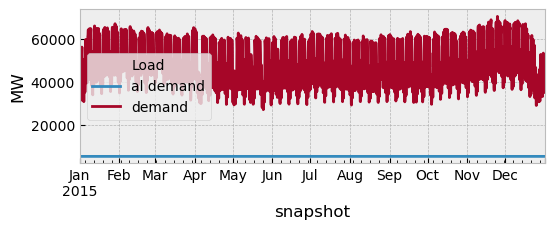

In [27]:
n.loads_t.p_set.plot(figsize=(6, 2), ylabel="MW")

We are going to add one dispatchable generation technology to the model. This is an open-cycle gas turbine (OCGT) with CO$_2$ emissions of 0.2 t/MWh$_{th}$.

In [28]:
n.add(
    "Generator",
    "OCGT",
    bus="electricity",
    carrier="OCGT",
    capital_cost=costs.at["OCGT", "capital_cost"],
    marginal_cost=costs.at["OCGT", "marginal_cost"],
    efficiency=costs.at["OCGT", "efficiency"],
    p_nom_extendable=True,
)

# 加上smelter
n.add(
    "Link", 
    "smelter", 
    bus0="electricity", 
    bus1="aluminum", # measured by eletricity
    p_nom=10 * 1e3, # 10 GW
    efficiency= 1, # MWh
)

# 使用 math.inf
n.add(
    "Store", 
    "aluminum storage", 
    bus="aluminum", 
    e_nom=float('inf'),  # 或者使用 float('inf')
    e_cyclic=True, 
)


Index(['aluminum storage'], dtype='object')

Adding the variable renewable generators works almost identically, but we also need to supply the capacity factors to the model via the attribute `p_max_pu`.

In [29]:
for tech in ["onwind", "offwind", "solar"]:
    n.add(
        "Generator",
        tech,
        bus="electricity",
        carrier=tech,
        p_max_pu=ts[tech],
        capital_cost=costs.at[tech, "capital_cost"],
        marginal_cost=costs.at[tech, "marginal_cost"],
        efficiency=costs.at[tech, "efficiency"],
        p_nom_extendable=True,
    )

So let's make sure the capacity factors are read-in correctly.

<Axes: xlabel='snapshot', ylabel='CF'>

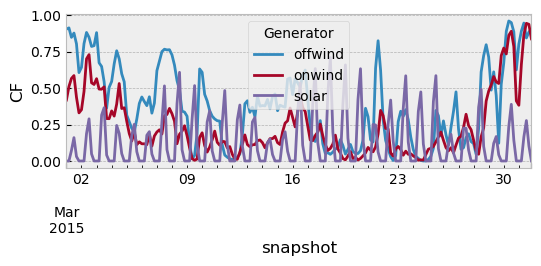

In [30]:
n.generators_t.p_max_pu.loc["2015-03"].plot(figsize=(6, 2), ylabel="CF")

### Model Run

Then, we can already solve the model for the first time. At this stage, the model does not have any storage or emission limits implemented. It's going to look for the least-cost combination of variable renewables and the gas turbine to supply demand.

In [31]:
n.optimize(solver_name="highs")

Index(['electricity', 'aluminum'], dtype='object', name='Bus')
Index(['smelter'], dtype='object', name='Link')
Index(['aluminum storage'], dtype='object', name='Store')
Index(['electricity', 'aluminum'], dtype='object', name='Bus')
Index(['smelter'], dtype='object', name='Link')
Index(['aluminum storage'], dtype='object', name='Store')
C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\linopy\common.py:147: UserWarning: coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.
  warn(
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 5/5 [00:00<00:00, 142.13it/s]
INFO:linopy.io: Writing time: 0.29s
INFO:linopy.solvers:Log file at C:\Users\dell\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
S

('ok', 'optimal')

### Model Evaluation

The total system cost in billion Euros per year:

In [32]:
n.objective / 1e9

31.130009817255424

The optimised capacities in GW:

In [33]:
n.generators.p_nom_opt.div(1e3)  # GW

Generator
OCGT       64.538520
onwind     -0.000000
offwind    53.990317
solar      91.710999
Name: p_nom_opt, dtype: float64

The total energy generation by technology in GW:

In [34]:
n.snapshot_weightings.generators @ n.generators_t.p.div(1e6)  # TWh

Generator
OCGT       215.082093
onwind       0.000000
offwind    164.731624
solar       99.112024
Name: generators, dtype: float64

While we get the objective value through `n.objective`, in many cases we want to know how the costs are distributed across the technologies. We can use the statistics module for this:

In [35]:
(n.statistics.capex() + n.statistics.opex()).div(1e6)

component  carrier
Generator  OCGT       16992.051976
           offwind     9427.838194
           solar       4710.119647
dtype: float64

Possibly, we are also interested in the total emissions:

In [36]:
emissions = (
    n.generators_t.p
    / n.generators.efficiency
    * n.generators.carrier.map(n.carriers.co2_emissions)
)  # t/h

In [37]:
n.snapshot_weightings.generators @ emissions.sum(axis=1).div(1e6)  # Mt

103.86891310391795

### Plotting Optimal Dispatch

This function takes the network object `n` as an argument and, optionally, a time frame. We want to plot the load time series, and stacked area charts for electricity feed-in and storage charging. Technologies should be coloured by their color defined in `n.carriers`.

In [38]:
def plot_dispatch(n, time="2015-07"):
    p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)

    if not n.storage_units.empty:
        sto = n.storage_units_t.p.T.groupby(n.storage_units.carrier).sum().T.div(1e3)
        p_by_carrier = pd.concat([p_by_carrier, sto], axis=1)

    fig, ax = plt.subplots(figsize=(6, 3))

    color = p_by_carrier.columns.map(n.carriers.color)

    p_by_carrier.where(p_by_carrier > 0).loc[time].plot.area(
        ax=ax,
        linewidth=0,
        color=color,
    )

    charge = p_by_carrier.where(p_by_carrier < 0).dropna(how="all", axis=1).loc[time]

    if not charge.empty:
        charge.plot.area(
            ax=ax,
            linewidth=0,
            color=charge.columns.map(n.carriers.color),
        )

    n.loads_t.p_set.sum(axis=1).loc[time].div(1e3).plot(ax=ax, c="k")

    plt.legend(loc=(1.05, 0))
    ax.set_ylabel("GW")
    ax.set_ylim(-200, 200)

Oje, that was complicated. Let's test it:

C:\Users\dell\AppData\Local\Temp\ipykernel_29548\184362636.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)


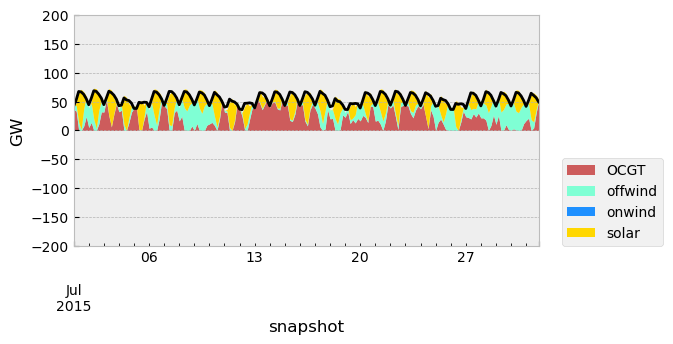

In [39]:
plot_dispatch(n)

## Adding Storage Units

Alright, but there are a few important components missing for a system with high shares of renewables? What about short-term storage options (e.g. batteries) and long-term storage options (e.g. hydrogen storage)? Let's add them too.

First, the battery storage. We are going to assume a fixed energy-to-power ratio of 6 hours, i.e. if fully charged, the battery can discharge at full capacity for 6 hours.
For the capital cost, we have to factor in both the capacity and energy cost of the storage. We are also going to enforce a cyclic state-of-charge condition, i.e. the state of charge
at the beginning of the optimisation period must equal the final state of charge.

In [40]:
n.add(
    "StorageUnit",
    "battery storage",
    bus="electricity",
    carrier="battery storage",
    max_hours=6,
    capital_cost=costs.at["battery inverter", "capital_cost"]
    + 6 * costs.at["battery storage", "capital_cost"],
    efficiency_store=costs.at["battery inverter", "efficiency"],
    efficiency_dispatch=costs.at["battery inverter", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
)

Index(['battery storage'], dtype='object')

Second, the hydrogen storage. This one is composed of an electrolysis to convert electricity to hydrogen, a fuel cell to re-convert hydrogen to electricity and underground storage (e.g. in salt caverns). We assume an energy-to-power ratio of 168 hours, such that this type of storage can be used for weekly balancing.

In [41]:
capital_costs = (
    costs.at["electrolysis", "capital_cost"]
    + costs.at["fuel cell", "capital_cost"]
    + 168 * costs.at["hydrogen storage underground", "capital_cost"]
)

n.add(
    "StorageUnit",
    "hydrogen storage underground",
    bus="electricity",
    carrier="hydrogen storage underground",
    max_hours=168,
    capital_cost=capital_costs,
    efficiency_store=costs.at["electrolysis", "efficiency"],
    efficiency_dispatch=costs.at["fuel cell", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
)

Index(['hydrogen storage underground'], dtype='object')

Ok, lets run the again, now with storage, and see what's changed.

In [42]:
# n.optimize(solver_name="highs")

In [43]:
# n.generators.p_nom_opt  # MW

In [44]:
# n.storage_units.p_nom_opt  # MW

**Nothing!** The objective value is the same, and no storage is built.

### Adding emission limits

The gas power plant offers sufficient and cheap enough backup capacity to run in periods of low wind and solar generation. But what happens if this source of flexibility disappears. Let's model a 100% renewable electricity system by adding a CO$_2$ emission limit as global constraint:

In [45]:
n.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=0,
)

Index(['CO2Limit'], dtype='object')

When we run the model now...

In [46]:
n.optimize(solver_name="highs")

Index(['electricity', 'aluminum'], dtype='object', name='Bus')
Index(['smelter'], dtype='object', name='Link')
Index(['aluminum storage'], dtype='object', name='Store')
Index(['electricity', 'aluminum'], dtype='object', name='Bus')
Index(['smelter'], dtype='object', name='Link')
Index(['aluminum storage'], dtype='object', name='Store')
C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\linopy\common.py:147: UserWarning: coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.
  warn(
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 96.00it/s]
INFO:linopy.io: Writing time: 0.53s
INFO:linopy.solvers:Log file at C:\Users\dell\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
St

('ok', 'optimal')

...and inspect the capacities built...

In [47]:
n.generators.p_nom_opt  # MW

Generator
OCGT           -0.000000
onwind     243808.250949
offwind     57548.088647
solar      249991.717445
Name: p_nom_opt, dtype: float64

In [48]:
n.storage_units.p_nom_opt  # MW

StorageUnit
battery storage                 40399.763341
hydrogen storage underground    45658.932810
Name: p_nom_opt, dtype: float64

In [49]:
n.storage_units.p_nom_opt.div(1e3) * n.storage_units.max_hours  # GWh

StorageUnit
battery storage                  242.398580
hydrogen storage underground    7670.700712
dtype: float64

... we see quite a bit of storage. So how does the optimised dispatch of the system look like?

C:\Users\dell\AppData\Local\Temp\ipykernel_26276\184362636.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
c:\ProgramData\Anaconda3\envs\pypsa-china\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1800: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(None, 0)


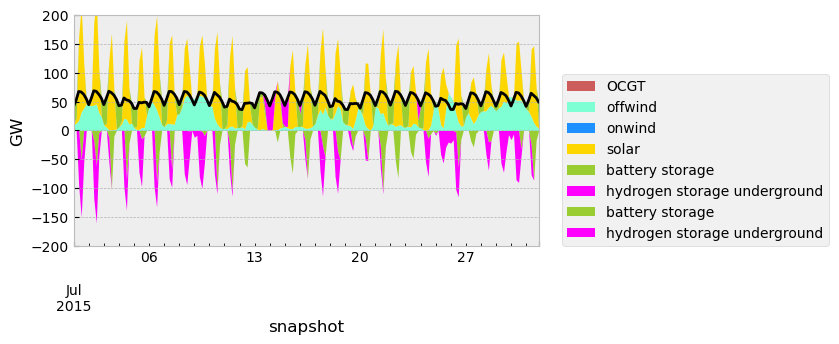

In [45]:
plot_dispatch(n)

We are also keen to see what technologies constitute the largest cost components. For that we're going to define a small helper function:

In [47]:
def system_cost(n):
    tsc = n.statistics.capex() + n.statistics.opex()
    return tsc.droplevel(0).div(1e6)  # million €/a

In [48]:
system_cost(n)

carrier
offwind                         12353.603388
onwind                          13532.296237
solar                           12476.814978
battery storage                          NaN
hydrogen storage underground             NaN
dtype: float64

This series, we can then process into plots, e.g. a pie chart:

<Axes: >

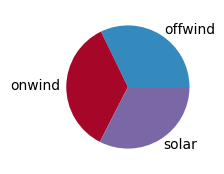

In [49]:
system_cost(n).plot.pie(figsize=(2, 2))

or use to compute the cost per unit of electricity consumed:

In [50]:
demand = n.snapshot_weightings.generators @ n.loads_t.p_set.sum(axis=1)

In [51]:
system_cost(n).sum() * 1e6 / demand.sum()

80.10159278964981

In [53]:
n.export_to_netcdf("network-new.nc")

INFO:pypsa.io:Exported network 'network-new.nc' contains: generators, carriers, storage_units, buses, loads, global_constraints


<xarray.Dataset> Size: 404kB
Dimensions:                               (snapshots: 2190,
                                           investment_periods: 0,
                                           generators_i: 4,
                                           generators_t_p_max_pu_i: 3,
                                           generators_t_p_i: 3, carriers_i: 6,
                                           storage_units_i: 2,
                                           ...
                                           storage_units_t_state_of_charge_i: 2,
                                           buses_i: 1, buses_t_p_i: 1,
                                           buses_t_marginal_price_i: 1,
                                           loads_i: 1, loads_t_p_set_i: 1,
                                           loads_t_p_i: 1,
                                           global_constraints_i: 1)
Coordinates: (12/18)
  * snapshots                             (snapshots) int64 18kB 0 1 ... 2189
  * investment_periods                    (investment_periods) int64 0B 
  * generators_i                          (generators_i) object 32B 'OCGT' .....
  * generators_t_p_max_pu_i               (generators_t_p_max_pu_i) object 24B ...
  * generators_t_p_i                      (generators_t_p_i) object 24B 'onwi...
  * carriers_i                            (carriers_i) object 48B 'onwind' .....
    ...                                    ...
  * buses_t_p_i                           (buses_t_p_i) object 8B 'electricity'
  * buses_t_marginal_price_i              (buses_t_marginal_price_i) object 8B ...
  * loads_i                               (loads_i) object 8B 'demand'
  * loads_t_p_set_i                       (loads_t_p_set_i) object 8B 'demand'
  * loads_t_p_i                           (loads_t_p_i) object 8B 'demand'
  * global_constraints_i                  (global_constraints_i) object 8B 'C...
Data variables: (12/43)
    snapshots_snapshot                    (snapshots) datetime64[ns] 18kB 201...
    snapshots_objective                   (snapshots) float64 18kB 4.0 ... 4.0
    snapshots_stores                      (snapshots) float64 18kB 4.0 ... 4.0
    snapshots_generators                  (snapshots) float64 18kB 4.0 ... 4.0
    investment_periods_objective          (investment_periods) object 0B 
    investment_periods_years              (investment_periods) object 0B 
    ...                                    ...
    buses_t_marginal_price                (snapshots, buses_t_marginal_price_i) float64 18kB ...
    loads_bus                             (loads_i) object 8B 'electricity'
    loads_t_p_set                         (snapshots, loads_t_p_set_i) float64 18kB ...
    loads_t_p                             (snapshots, loads_t_p_i) float64 18kB ...
    global_constraints_sense              (global_constraints_i) object 8B '<='
    global_constraints_mu                 (global_constraints_i) float64 8B -...
Attributes:
    network__linearized_uc:      0
    network__multi_invest:       0
    network_name:                
    network_objective:           79406619874.64291
    network_objective_constant:  0.0
    network_pypsa_version:       0.31.1
    network_srid:                4326
    crs:                         {"_crs": "GEOGCRS[\"WGS 84\",ENSEMBLE[\"Worl...
    meta:                        {}

:::{warning}
Always consider, that the load data is given in units of power (MW) and if your resolution is not hourly, you need to multiply by the snapshot weighting to get the energy consumed!
:::

## Sensitivity Analysis

Sensitivity analyses constitute a core activity of energy system modelling. Below, you can find sensitivity analyses regarding the

1. variation in allowed CO$_2$ emissions
2. variation in solar overnight costs
3. variation in offshore wind potentials

In [54]:
sensitivity = {}
for co2 in [150, 100, 50, 25, 0]:
    n.global_constraints.loc["CO2Limit", "constant"] = co2 * 1e6
    n.optimize(solver_name="highs")
    sensitivity[co2] = system_cost(n)

Index(['electricity'], dtype='object', name='Bus')
Index(['electricity'], dtype='object', name='Bus')
C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\linopy\common.py:147: UserWarning: coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.
  warn(
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 111.36it/s]
INFO:linopy.io: Writing time: 0.49s
INFO:linopy.solvers:Log file at C:\Users\dell\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 21906 primals, 50381 duals
Objective: 3.16e+10
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-low

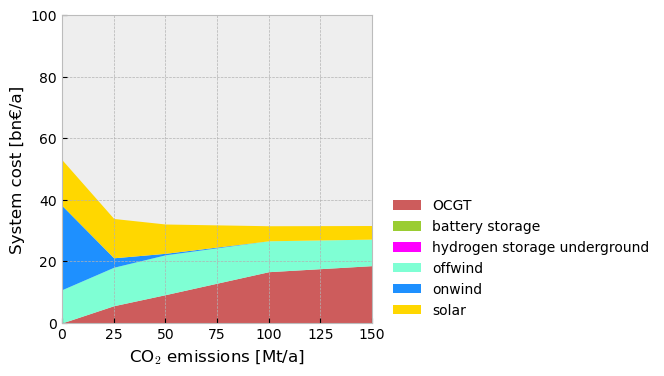

In [55]:
df = pd.DataFrame(sensitivity).T.div(1e3)  # billion Euro/a
df.plot.area(
    stacked=True,
    linewidth=0,
    color=df.columns.map(n.carriers.color),
    figsize=(4, 4),
    xlim=(0, 150),
    xlabel=r"CO$_2$ emissions [Mt/a]",
    ylabel="System cost [bn€/a]",
    ylim=(0, 100),
)
plt.legend(frameon=False, loc=(1.05, 0))